<a href="https://colab.research.google.com/github/asangphukieo/Gut_microbiota_workshop_CMUTEAM_2022/blob/main/6_Data_preprocessing_by_QIIME2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data preprocessing by QIIME2

* To follow this tutorial on google colab, we need to install QIIME2 by anaconda.

In [ ]:

# INSTALL CONDA ON GOOGLE COLAB

! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [ ]:
#Download QIIME2 installer file
! wget https://data.qiime2.org/distro/core/qiime2-2022.2-py38-linux-conda.yml

In [ ]:
#Install QIIME2 in conda base environment
! conda env update --file qiime2-2022.2-py38-linux-conda.yml --name base

In [ ]:
#Test command
! qiime

## Data preprocessing steps by QIIME2¶
The processing steps we’ll cover in this tutorial include:

1.   Importing raw sequence (FASTQ) data into QIIME2
2.   Demultiplexing data (i.e. mapping each sequence to the sample it came from)
3.   Removing non-biological parts of the sequences (i.e. primers)
4. Performing quality control and:
  * denoising sequences with DADA2 or deblur, and/or
  * quality filtering, length trimming, and clustering with VSEARCH or dbOTU


Conceptual overview of QIIME 2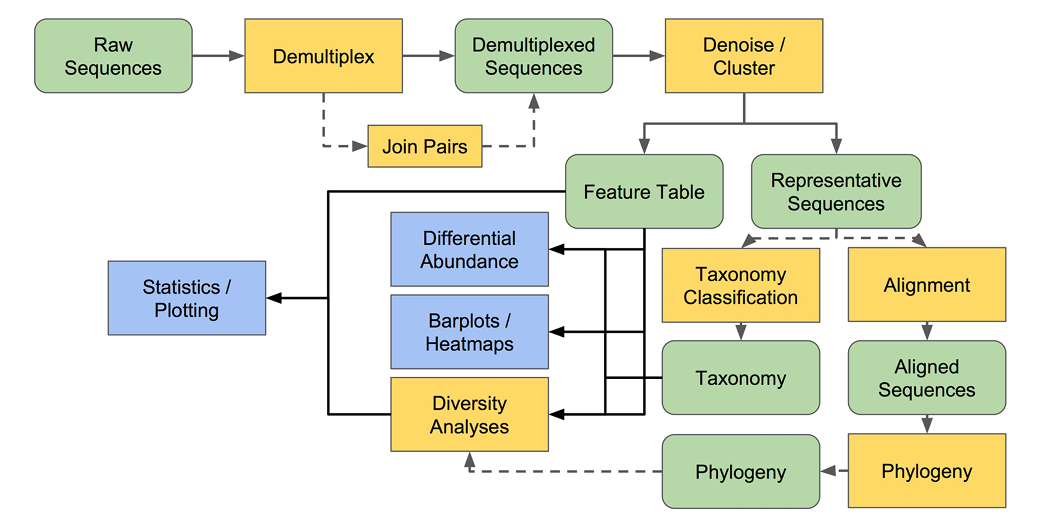

### 1. Import DNA sequence data into QIIME2
* QIIME2 allows us to import and export data at many different steps. 
* High-thoughput amplicon sequencing is in FASTQ format. 
  * Single-end or paired-end ? 
  * Multiplexed or demultiplexed format ? 
* Multiplexed files : 
  * File1 – sequences 
  * File2 – barcode 
* Demultiplexed files: 
  * One (two) sequence file(s) per sample 




In [ ]:
# Download example dataset
! mkdir 00.rawdata/
! wget https://figshare.com/ndownloader/files/36523497 -O 00.rawdata/SRR12595759_1.fastq.gz
! wget https://figshare.com/ndownloader/files/36523500 -O 00.rawdata/SRR12595759_2.fastq.gz
! wget https://figshare.com/ndownloader/files/36523515 -O 00.rawdata/SRR12595761_1.fastq.gz
! wget https://figshare.com/ndownloader/files/36523518 -O 00.rawdata/SRR12595761_2.fastq.gz
! wget https://figshare.com/ndownloader/files/36523506 -O 00.rawdata/SRR12595760_1.fastq.gz
! wget https://figshare.com/ndownloader/files/36523512 -O 00.rawdata/SRR12595760_2.fastq.gz
! wget https://figshare.com/ndownloader/files/36523521 -O 00.rawdata/SRR12595762_1.fastq.gz
! wget https://figshare.com/ndownloader/files/36523524 -O 00.rawdata/SRR12595762_2.fastq.gz
! ls


### Create manifest file 
* Manifest file can be created by many methods: excel, text editor, command lines, and etc. Write header of manifest file. 
Example manifest file
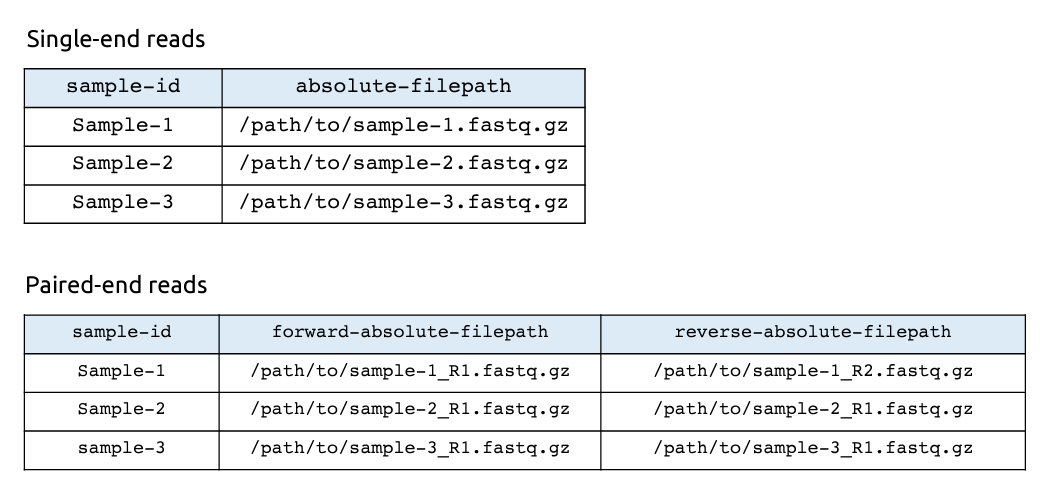

In [42]:
#Create manifest file
! echo -e "sample-id\tforward-absolute-filepath\treverse-absolute-filepath" > manifest.tsv

! for f in `ls 00.rawdata/*_1.fastq.gz`; \
    do n=`basename -s _1.fastq.gz $f`; \
    fwp=/content/00.rawdata/$n"_1.fastq.gz"; \
    rwp=/content/00.rawdata/$n"_2.fastq.gz"; \
    echo -e $n"\t"$fwp"\t"$rwp; \
    done >> manifest.tsv

In [43]:
#View manifeest file
! cat manifest.tsv

sample-id	forward-absolute-filepath	reverse-absolute-filepath
SRR12595759	/content/00.rawdata/SRR12595759_1.fastq.gz	/content/00.rawdata/SRR12595759_2.fastq.gz
SRR12595760	/content/00.rawdata/SRR12595760_1.fastq.gz	/content/00.rawdata/SRR12595760_2.fastq.gz
SRR12595761	/content/00.rawdata/SRR12595761_1.fastq.gz	/content/00.rawdata/SRR12595761_2.fastq.gz
SRR12595762	/content/00.rawdata/SRR12595762_1.fastq.gz	/content/00.rawdata/SRR12595762_2.fastq.gz


### Create metadata file
* Metadata are the data that explain samples in several characteristics. Metadata can be used to study the association between microbiota and sample’s characteristics. 
* Example metadata file
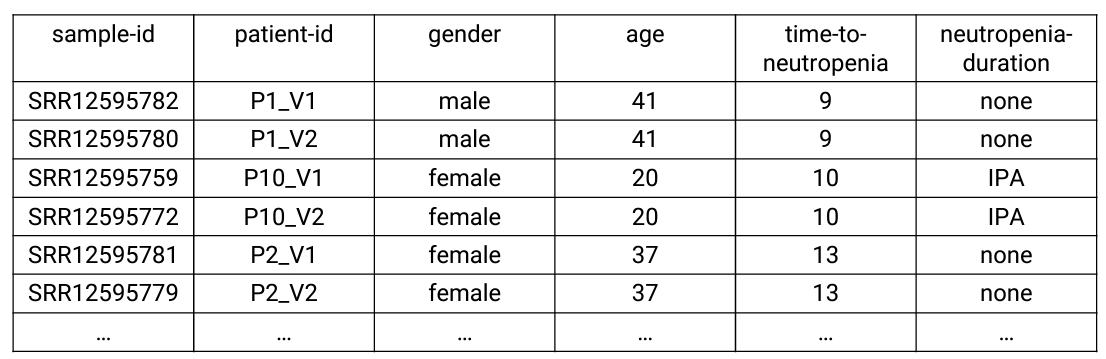

In [58]:
#Create metasdata file by commandline
! echo -e """sample-id	patient-id	gender	age	time-to-neutropenia	neutropenia-duration\nSRR12595759	P10_V1	female	20	10	E. coli septicemia; IPA\nSRR12595760	P9_V1	female	44	11	none\nSRR12595761	P8_V1	female	49	12	none\nSRR12595762	P7_V1	male	44	12	none\n""" > 00.sample-metadata.tsv

### Import sequence data into QIIME2

In [44]:
# Import sequence data into QIIME2 using the manifest file 
! qiime tools import \
    --input-path manifest.tsv \
    --type 'SampleData[PairedEndSequencesWithQuality]' \
    --input-format PairedEndFastqManifestPhred33V2 \
    --output-path 01.sequence.qza

Imported manifest.tsv as PairedEndFastqManifestPhred33V2 to 01.sequence.qza


In [45]:
! qiime demux summarize \
    --i-data 01.sequence.qza \
    --o-visualization 01.sequence.qzv

QIIME is caching your current deployment for improved performance. This may take a few moments and should only happen once per deployment.
Saved Visualization to: 01.sequence.qzv


## Trim adapter sequences
* Adapter & Primer Sequences



Primers for V3-V4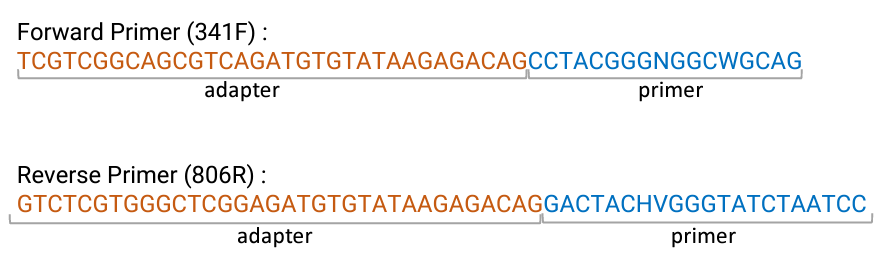

In [47]:
#Trim a single set of primer sequences
! qiime cutadapt trim-paired \
    --i-demultiplexed-sequences 01.sequence.qza \
    --p-cores 4 \--p-front-f TCGTCGGCAGCGTCAGATGTGTATAAGAGACAGCCTACGGGNGGCWGCAG \
    --p-front-r GTCTCGTGGGCTCGGAGATGTGTATAAGAGACAGGACTACHVGGGTATCTAATCC \
    --o-trimmed-sequences 02.sequence-adapter-trimmed.qza

Saved SampleData[PairedEndSequencesWithQuality] to: 02.sequence-adapter-trimmed.qza


* If you need to trim with Multiple sets of primer sequences 
```
! qiime cutadapt trim-paired \
    --i-demultiplexed-sequences 01.sequence.qza \
    --p-cores 4 \
    --p-front-f file:00.forward-primer-V4.fasta \
    --p-front-r file:00.reverse-primer-V4.fasta \
    --o-trimmed-sequences 02.sequence-rmadapter.qza
```



### Summarize and Visualize by QIIME2view web browser

In [50]:
#Summarize and visualize
! qiime demux summarize \
    --i-data 02.sequence-adapter-trimmed.qza \
    --o-visualization 02.sequence-adapter-trimmed.qzv

Saved Visualization to: 02.sequence-adapter-trimmed.qzv


## Denoise sequence data


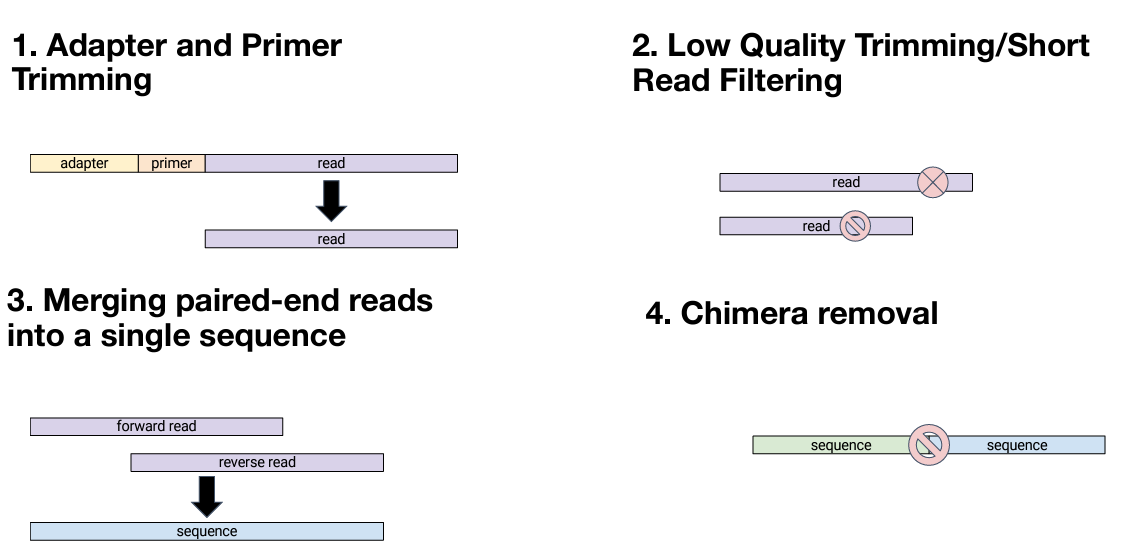

## Dereplication based on ASV
* Grouping sequences belonging to the same organisms into a representative sequence


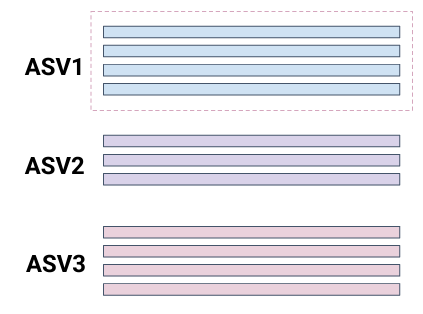

ref: Callahan, B., McMurdie, P. & Holmes, S. Exact sequence variants should replace operational taxonomic units in marker-gene data analysis. ISME J 11, 2639–2643 (2017). https://doi.org/10.1038/ismej.2017.119

In [52]:
#Denoise sequence data
! qiime dada2 denoise-paired \
    --i-demultiplexed-seqs 02.sequence-adapter-trimmed.qza \
    --p-trunc-len-f 0 \
    --p-trunc-len-r 0 \
    --p-n-threads 8 \
    --o-table 03.table.qza \
    --o-representative-sequences 03.rep-seqs.qza \
    --o-denoising-stats 03.stats.qza

Saved FeatureTable[Frequency] to: 03.table.qza
Saved FeatureData[Sequence] to: 03.rep-seqs.qza
Saved SampleData[DADA2Stats] to: 03.stats.qza


## Tabulate sequence data into statistics table

In [59]:
 #Tabulate sequence data into statistics table
! qiime metadata tabulate \
    --m-input-file 03.stats.qza \
    --o-visualization 03.stats.qzv 
    
! qiime feature-table summarize \
    --i-table 03.table.qza \
    --o-visualization 03.table.qzv \
    --m-sample-metadata-file 00.sample-metadata.tsv

Saved Visualization to: 03.stats.qzv
Saved Visualization to: 03.table.qzv


In [60]:
#Tabulate sequence data into statistics table of feature sequences
! qiime feature-table tabulate-seqs \
    --i-data 03.rep-seqs.qza \
    --o-visualization 03.rep-seqs.qzv

Saved Visualization to: 03.rep-seqs.qzv


## Filter sequencesand summarize

In [61]:
! qiime feature-table filter-features \
--i-table 03.table.qza \
--p-min-frequency 1 \
--o-filtered-table 04.table-rm1.qza 

Saved FeatureTable[Frequency] to: 04.table-rm1.qza


In [62]:
! qiime feature-table summarize \
--i-table 04.table-rm1.qza \
--o-visualization 04.table-rm1.qzv \
--m-sample-metadata-file 00.sample-metadata.tsv 

Saved Visualization to: 04.table-rm1.qzv


In [63]:
! qiime feature-table filter-seqs \
--i-data 03.rep-seqs.qza \
--i-table 04.table-rm1.qza \
--o-filtered-data 04.rep-seqs-rm1.qza 

Saved FeatureData[Sequence] to: 04.rep-seqs-rm1.qza


In [64]:
! qiime feature-table tabulate-seqs \
--i-data 04.rep-seqs-rm1.qza \
--o-visualization 04.rep-seqs-rm1.qzv

Saved Visualization to: 04.rep-seqs-rm1.qzv
